In [102]:
def conditiondct(conditionlist=[],startstop=[[]]):
    cd={}
    for i in range(len(conditionlist)):
        llist=[]
        for j in range(startstop[i][0],startstop[i][1]+1):
            llist.append("L"+str(j))
        cd[conditionlist[i]]=llist
    return cd

In [ ]:
genelist=['Dapi','Glul','Cps1','Gls2']#order of channels
path=r"your/destination/path"
imagepath=r"your/image/path"
conditiondict=conditiondct(["CON","L-KO"],[[16,21],[25,31]])#["CON","L-KO"],[[firstmouse1,finalmouse1],[firstmouse2,finalmouse2]]
channeldict={"C1":genelist[0],"C2":genelist[1],"C3":genelist[2],"C4":genelist[3]}

In [10]:
####    LOAD LIBRARIES/PACKAGES    ####
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bigfish.detection as detection
import bigfish.stack as stack
import bigfish.plot as plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import sys
import re
import math
import json
from tqdm import tqdm 
import importlib
from pathlib import Path
from skimage.draw import polygon_perimeter, polygon
from skimage import io
from skimage.io import imread, imsave
from scipy import ndimage
from scipy import stats
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import shutil
import statsmodels.api as sm

In [ ]:
####    PREPROCESS    ####
ncpath=os.path.join(path+"Negative Controls/")
try:
    os.mkdir(ncpath)
except:
    pass
for i in os.listdir(imagepath):
    if i.endswith(".tif"):
        dire=os.path.join(path,i.rsplit('.',1)[0])
        try:
            os.mkdir(dire)
        except:
            pass
if genelist[0]!='Dapi':
    for i,j in enumerate(genelist):
        if j == 'Dapi':
            dapiindex=i
            for k in os.listdir(imagepath):
                l=list(k)
                if l[1]==str(1):
                    l[1]=str(5)
                    os.rename(imagepath+k,imagepath+"".join(list(l)))
            for k in os.listdir(imagepath):
                l=list(k)
                if l[1]==str(i+1):
                    l[1]=str(1)
                    os.rename(imagepath+k,imagepath+"".join(list(l)))
            for k in os.listdir(imagepath):
                l=list(k)
                if l[1]==str(5):
                    l[1]=str(i+1)
                    os.rename(imagepath+k,imagepath+"".join(list(l)))
    genelist.append(genelist[0])
    genelist[0]=genelist[dapiindex]
    genelist[dapiindex]=genelist[4]
    genelist=genelist[0:4]
    print("Updated Genelist: "+str(genelist))
try:
    os.mkdir(os.path.join(path,"","Thresholding"))
except:
    pass
for i in genelist:
    if i!='Dapi':
        i=os.path.join(path,'Thresholding',i)
        try:
            os.mkdir(i)
        except:
            pass

In [ ]:
####    CELLPROFILER    ####

In [ ]:
####    MOVE NEGATIVE CONTROLS    ####
for i in os.listdir(path):
    if i.endswith(")"):
        shutil.move(os.path.join(path,i), os.path.join(ncpath,i))

In [ ]:
####    THRESHOLDING FUNCTIONS    ####
def run_thresholding(img, voxel_size=(3,3), spot_radius=(5,5)):#from patrick
    spots,thresh= detection.detect_spots(
                    images = img,
                    voxel_size=voxel_size,
                    return_threshold=True,
                    spot_radius=spot_radius)
    
    spots_post_decomposition, _, _ = detection.decompose_dense(
                    image=img,
                    spots=spots,
                    voxel_size=voxel_size,
                    spot_radius=spot_radius,
                    alpha=0.5,#mess with this for intensity stuff - higher = less
                    beta=1,
                    gamma=5)
    spots_post_clustering, clusters = detection.detect_clusters(
                    spots=spots_post_decomposition,
                    voxel_size=voxel_size,
                    radius=350,
                    nb_min_spots=4)
    return spots_post_clustering, thresh
def check_thresholding(img, threshold, voxel_size=(103,103), spot_radius=(150,150)):#from patrick
    spots= detection.detect_spots(
                    images = img,
                    threshold = threshold,
                    voxel_size=voxel_size,
                    spot_radius=spot_radius)
    
    spots_post_decomposition, _, _ = detection.decompose_dense(
                    image=img,
                    spots=spots,
                    voxel_size=voxel_size,
                    spot_radius=spot_radius,
                    alpha=0.5,#mess with this for intensity stuff - higher = less
                    beta=1,
                    gamma=5)
    spots_post_clustering, clusters = detection.detect_clusters(
                    spots=spots_post_decomposition,
                    voxel_size=voxel_size,
                    radius=350,
                    nb_min_spots=4)
    
    return spots_post_clustering

In [ ]:
####    RUN THRESHOLDING    ####
for i in os.listdir(ncpath):
    if re.search("^L[0-9]",i):
        c2 = stack.read_image(ncpath+i + '/C2.tiff')
        c3 = stack.read_image(ncpath+i + '/C3.tiff')
        c4 = stack.read_image(ncpath+i + '/C4.tiff')
        c2_spots,c2_thresh=run_thresholding(c2)
        c3_spots,c3_thresh=run_thresholding(c3)
        c4_spots,c4_thresh=run_thresholding(c4)
        print(i.split("_")[-1]+"  C2: "+str(c2_thresh)+"   C3: "+str(c3_thresh)+"   C4: "+str(c4_thresh))
#         plot.plot_detection(c2, spots=c2_spots[:, :2], shape = 'circle',
#                             radius=3, color='red', linewidth=1, fill=False, contrast=False,
#                             title=genelist[1]+ ": "+str(c2_thresh), ext='png', show=False,
#                             path_output=os.path.join(path,"Thresholding",genelist[1], (i + '_spot_detection')));

#         plot.plot_detection(c3, spots=c3_spots[:, :2], shape = 'circle',
#                             radius=3, color='red', linewidth=1, fill=False, contrast=False,
#                             title=genelist[2]+ ": "+str(c3_thresh), ext='png', show=False,
#                             path_output=os.path.join(path,"Thresholding", genelist[2], (i+ '_spot_detection')));

#         plot.plot_detection(c4, spots=c4_spots[:, :2], shape = 'circle',
#                             radius=3, color='red', linewidth=1, fill=False, contrast=False,
#                             title=genelist[3]+ ": "+str(c4_thresh), ext='png', show=False,
#                             path_output=os.path.join(path ,"Thresholding", genelist[3],(i + '_spot_detection')));


In [ ]:
threshlist=[0,40,70,50]

In [ ]:
####    CHECK THRESHOLDING    ####
print(genelist)
for i in os.listdir(ncpath):
    if re.search("^L[0-9]",i):
        c2 = stack.read_image(ncpath+i + '/C2.tiff')
        c3 = stack.read_image(ncpath+i + '/C3.tiff')
        c4 = stack.read_image(ncpath+i + '/C4.tiff')
        c2_spots=check_thresholding(c2,threshlist[1])
        c3_spots=check_thresholding(c3,threshlist[2])
        c4_spots=check_thresholding(c4,threshlist[3])
        #print(i.split("_")[-1]+"  C2: "+str(len(c2_spots))+"   C3: "+str(len(c3_spots))+"   C4: "+str(len(c4_spots)))
        print(i)
        plot.plot_detection(c2, spots=c2_spots[:, :2], shape = 'circle',
                    radius=3, color='red', linewidth=1, fill=False, contrast=False,
                    title=genelist[1]+ ": "+str(threshlist[1]), ext='png', show=True,
                    path_output=os.path.join(path,"Thresholding",genelist[1],(i + '_spot_detection')));

        plot.plot_detection(c3, spots=c3_spots[:, :2], shape = 'circle',
                    radius=3, color='red', linewidth=1, fill=False, contrast=False,
                    title=genelist[2]+ ": "+str(threshlist[2]), ext='png', show=True,
                    path_output=os.path.join(path,"Thresholding", genelist[2],(i+ '_spot_detection')));

        plot.plot_detection(c4, spots=c4_spots[:, :2], shape = 'circle',
                    radius=3, color='red', linewidth=1, fill=False, contrast=False,
                    title=genelist[3]+ ": "+str(threshlist[3]), ext='png', show=True,
                    path_output=os.path.join(path ,"Thresholding", genelist[3],(i + '_spot_detection')));

In [ ]:
def colorbar(mappable):
    """
    Function to place colorbars next to images and guarantee that they have the
    same size.
    From: https://joseph-long.com/writing/colorbars/
    More info: https://matplotlib.org/mpl_toolkits/axes_grid/users/overview.html#colorbar-whose-height-or-width-in-sync-with-the-master-axes
    """
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    return fig.colorbar(mappable, cax=cax)

def log_message(msg, callback_fun=None):
    """ Display log, either terminal or any callback accepting a string as input.
    Parameters
    ----------
    msg : [string]
        [description]
    callback_fun : [type], optional
        [description], by default None
    """
    if callback_fun:
        callback_fun(msg)
    else:
        print(msg)

# Function to create filled masks
def make_mask(roi_pos,img_size):
    rr, cc = polygon(roi_pos[:, 0], roi_pos[:, 1])
    # Make sure it's not outside
    rr[rr < 0] = 0
    rr[rr > img_size[0] - 1] = img_size[0] - 1
    cc[cc < 0] = 0
    cc[cc > img_size[1] - 1] = img_size[1] - 1
    # Generate mask
    mask = np.zeros(img_size, dtype=np.uint8)
    mask[rr, cc] = 1
    return mask

def read_annotation(annotation_file):
    # Load annotation from json file: Note that the coordinates in the annotations
    # are stored as (X,Y), further  Y has to be flipped
    if not os.path.isfile(annotation_file):
        raise FileNotFoundError(f"No annotation file found : {annotation_file}")
    with open(annotation_file, encoding='utf-8-sig') as fh:
        data_json = json.load(fh)
    # Read image size from annotations
    if 'bbox' in data_json:
        img_size = (int(data_json['bbox'][2]-data_json['bbox'][0]+1),
                           int(data_json['bbox'][3]-data_json['bbox'][1]+1))
        img_size = (img_size[1],img_size[0])
    return data_json, img_size
  


def run_detection(img, threshold, voxel_size=(103,103), spot_radius=(150,150)):
    spots= detection.detect_spots(
                    images = img,
                    threshold = threshold,
                    voxel_size=voxel_size,
                    spot_radius=spot_radius)
    
    spots_post_decomposition, _, _ = detection.decompose_dense(
                    image=img,
                    spots=spots,
                    voxel_size=voxel_size,
                    spot_radius=spot_radius,
                    alpha=0.5,
                    beta=1,
                    gamma=5)
    return spots_post_decomposition

def makejson(folder):
    cv=np.load(folder+"/CV.npy")
    pl=np.load(folder+"/PL.npy")
    cvl=[]
    pll=[]
    for i in range(len(np.where(cv==1)[1])):
        cvl.append([int(np.where(cv==1)[1][i]),cv.shape[0]-int(np.where(cv==1)[0][i])])
    for i in range(len(np.where(pl==1)[1])):
        pll.append([int(np.where(pl==1)[1][i]),pl.shape[0]-int(np.where(pl==1)[0][i])])
    
    annotations={"type":"FeatureCollection","features":[{"type":"Feature","geometry":{"type":"polygon","coordinates":[cvl]},"properties":{"label":"CV"}},{"type":"Feature","geometry":{"type":"polygon","coordinates":[pll]},"properties":{"label":"PL"}}],"bbox":[0,0,len(cv[0]),len(cv[:,0])]}
    file1=open(folder+"/annotation.json","wt")
    file1.write(json.dumps(annotations))
    file1.close()
    
def read_FQ_matlab(file_open):
  path=file_open.rsplit("\\",1)[0]
  file=file_open.split('\\')[-1]
  gene=genelist[int(file.split('-')[0][1])-1]
  img = stack.read_image(file_open)
  threshold=threshlist[int(file.split('-')[0][1])-1]
  spots=run_detection(img,threshold)
  dapi= path+"/C"+str(genelist.index('Dapi'))
  fq_dict={'gene':gene,'spots':spots,"img":img,"file_names":{"smFISH":file_open,"Dapi":dapi}}
  return fq_dict

def get_rna(fq_dict):
  return fq_dict['spots']

def folder_scan_process(folder_root,log_msg_callback = None,log_prog_callback=None):
    ''' Scan folders an process when C1 file is present'''
    region_labels   = ('CV','PL')
    # Recursive search of specified directory
    folders_proc = []
    for root, dirnames, filenames in os.walk(folder_root):
        for filename in filenames:
            if filename.startswith("C1"):
                folders_proc.append(root)
    for folder_process in folders_proc:
        log_message(f'\n\n Processing folder: {folder_process}',callback_fun=log_msg_callback)
        process_folder(folder_process,region_labels,log_msg_callback=log_msg_callback,log_prog_callback=log_prog_callback)
def process_folder(folder_process,region_labels,log_msg_callback = None,log_prog_callback=None):
    '''
    Process folder containing FQ analysis results and an ImJoy annotation.
    '''
    if 'annotation.json'not in os.listdir(folder_process):
        makejson(folder_process)
    # Open annotations and create masks
    annotation_file = os.path.join(folder_process,"annotation.json")
    data_json, img_size =read_annotation(annotation_file)

    # Note that coordinates are exchanged and y flipped
    for feat_idx, feat in enumerate(data_json['features']):
        label = feat['properties']['label']

        if label == region_labels[0]:
            log_message(f'Annotation for first region ({region_labels[0]}) found',callback_fun=log_msg_callback)
            cv_pos = np.squeeze(np.asarray(feat['geometry']['coordinates']))
            cv_pos[:,[0, 1]] = cv_pos[:,[1, 0]]
            cv_pos[:,0] = -1*cv_pos[:,0]+img_size[0]
            reg1_mask = make_mask(cv_pos,img_size)

        elif label == region_labels[1]:
            log_message(f'Annotation for second region ({region_labels[1]}) found',callback_fun=log_msg_callback)
            pl_pos = np.squeeze(np.asarray(feat['geometry']['coordinates']))
            pl_pos[:,[0, 1]] = pl_pos[:,[1, 0]]
            pl_pos[:,0] = -1*pl_pos[:,0]+img_size[0]
            reg2_mask = make_mask(pl_pos,img_size)

    ### Make masks and measure distance of P.L. to C.V.

    # Assemble distance map: outside positive, inside negative
    reg1_mask_distTrans_inside = ndimage.distance_transform_edt(reg1_mask)
    reg1_mask_distTrans_outside = ndimage.distance_transform_edt(~reg1_mask.astype(bool))

    reg1_mask_distTrans = np.copy(reg1_mask_distTrans_outside)
    reg1_mask_distTrans[reg1_mask_distTrans_inside>0] = -reg1_mask_distTrans_inside[reg1_mask_distTrans_inside>0]
    
    ### Test
    reg2_mask_distTrans_inside = ndimage.distance_transform_edt(reg2_mask)
    reg2_mask_distTrans_outside = ndimage.distance_transform_edt(~reg2_mask.astype(bool))

    reg2_mask_distTrans = np.copy(reg2_mask_distTrans_outside)
    reg2_mask_distTrans[reg2_mask_distTrans_inside>0] = -reg2_mask_distTrans_inside[reg2_mask_distTrans_inside>0]

    # Center of mass of region 2 (portal lobe)
    reg2_com      = np.asarray(ndimage.measurements.center_of_mass(reg2_mask.astype(bool))).astype('int')
    reg2_mask_dist= ndimage.distance_transform_edt(reg2_mask)
    reg2_dist = reg2_mask_dist[reg2_com[0],reg2_com[1]]
    reg2_distReg1 = reg1_mask_distTrans[reg2_com[0],reg2_com[1]]-reg2_dist

    
    # Loop over all FQ result files
    for file in os.listdir(folder_process):
        if '.tif' in file:

            file_open = os.path.join(folder_process,file)

            # Get information (path, file name) to save results
            drive, path_and_file = os.path.splitdrive(file_open)
            path, file = os.path.split(path_and_file)
            file_base, ext = os.path.splitext(file)

            path_save = os.path.join(drive,path, 'analysis__exprGradient')
            if not os.path.isdir(path_save):
                os.makedirs(path_save)

            fq_dict = read_FQ_matlab(file_open)
            spots_all = get_rna(fq_dict)
            spots_pos = spots_all[:,[0, 1]].astype('int')

            # Open FISH image
            file_FISH_img = os.path.join(folder_process,fq_dict['file_names']['smFISH'])
            img_FISH  = imread(file_FISH_img)

            ### Distance measurements
            reg1_mask_distTrans_norm = np.divide(reg1_mask_distTrans,reg1_mask_distTrans+reg2_mask_distTrans)

            # Distance of all RNAs to region 1, RNAs inside the region have negative values
            RNAdist_norm = reg1_mask_distTrans_norm[spots_pos[:,0],spots_pos[:,1]]

            # Bins for histogram
            RNAdist_norm_max = np.amax(RNAdist_norm)
            RNAdist_norm_min = np.amin(RNAdist_norm)
            bins=np.arange(np.around(RNAdist_norm_min,1)-0.1,RNAdist_norm_max+0.1,0.1)


            width = 0.8 * (bins[1] - bins[0])
            center = (bins[:-1] + bins[1:]) / 2

            # Histogram of RNA distances
            count_RNA, bins = np.histogram(RNAdist_norm, bins=bins,density=False)

            # Renormalize considering how many pixels are really in the actual image
            count_pix = np.diff(list(map(lambda threshold: np.sum(reg1_mask_distTrans_norm <= threshold),bins)))

            # Renormalize RNA counts with respect to area
            count_RNA_normArea = count_RNA/count_pix

            # Summarize all histograms
            hist_all = np.stack((center,count_RNA_normArea,count_RNA,count_pix),axis=1)

            # Save file with histogram
            np.savetxt(os.path.join(path_save, 'hist_expression__' + file_base +  '.txt'), hist_all, fmt='%f \t %f \t %f \t %f',header='Dist_norm [um]\tCOUNTS_NORM_AREA\tCOUNTS_RAW\tPIXEL_COUNTS')

            # Plot results and save figure

            # PLOT ROI and center of mass
            fig1, ax = plt.subplots(3,2,num='dist_enrich')
            fig1.set_size_inches((15,12))

            # Plot image with region of interest and reference point
            img1 = ax[0][0].imshow(img_FISH,cmap="hot")
            plt.sca(ax[0][0])   # set current axis
            plt.title('Region 1 (green) and 2 (blue)')
            ax[0][0].plot(pl_pos[:,1], pl_pos[:,0], '-b',alpha=0.5)
            ax[0][0].plot(cv_pos[:,1], cv_pos[:,0], '-g',alpha=0.5)
            ax[0][0].get_xaxis().set_visible(False)
            ax[0][0].get_yaxis().set_visible(False)
            colorbar(img1)

            img2 = ax[0][1].imshow(np.digitize(reg1_mask_distTrans_norm,bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]),cmap="hot")
            plt.sca(ax[0][1])
            plt.title('Detected Spots')
            ax[0][1].plot(pl_pos[:,1], pl_pos[:,0], '-b',alpha=0.5)
            ax[0][1].plot(cv_pos[:,1], cv_pos[:,0], '-g',alpha=0.5)
            ax[0][1].scatter(spots_pos[:,1],spots_pos[:,0],c='cyan',edgecolor='black',marker='.')
            ax[0][1].get_xaxis().set_visible(False)
            ax[0][1].get_yaxis().set_visible(False)

            # Plot distance map and pixel distance histogram
            img3 = ax[1][0].imshow(np.digitize(reg1_mask_distTrans_norm,bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]),cmap="hot")
            plt.sca(ax[1][0])
            plt.title('Renormalized distance from region 1')
            ax[1][0].plot(pl_pos[:,1], pl_pos[:,0], '-b')
            ax[1][0].plot(cv_pos[:,1], cv_pos[:,0], '-g')
            ax[1][0].get_xaxis().set_visible(False)
            ax[1][0].get_yaxis().set_visible(False)
            colorbar(img3)

            plt.sca(ax[1][1])
            plt.xlim([0,1])
            plt.title('Histogram of all pixel distances')
            ax[1][1].bar(center, count_pix, align='center', width=width)
            ax[1][1].set_xlabel('Distance [pixel]')
            ax[1][1].set_ylabel('# pixel')


            # Plot histograms
            plt.sca(ax[2][0])
            plt.xlim([0,1])
            plt.title('Histogram without normalization')
            ax[2][0].bar(center, count_RNA, align='center', width=width)
            ax[2][0].set_xlabel('Distance [pixel]')
            ax[2][0].set_ylabel('# RNAs')

            plt.sca(ax[2][1])
            plt.xlim([0,1])
            plt.title('Histogram: normalized with area')
            ax[2][1].bar(center, count_RNA_normArea, align='center', width=width)
            ax[2][1].set_xlabel('Normalized distance')
            ax[2][1].set_ylabel('Expression level [a.u.]')

            fig1.tight_layout(h_pad=0.2)
            plt.draw()

            plt.savefig(os.path.join(path_save, '_summary_gradient_' + file_base +  '.png'),dpi=200)
            plt.close()

    log_message(f'Finished processing data!',callback_fun=log_msg_callback)

In [ ]:
####    ANALYSIS    ####
folder_scan_process(path,log_msg_callback=None,log_prog_callback=None)

In [ ]:
####    COMPILE TXT FILES    ####
for r,d,fi in os.walk(path):
    for f in fi:
        if ".txt" in f and f.startswith("hist"):
            for channel in channeldict:
                if channel in f:
                    for key in conditiondict:
                        if r.rsplit("/",2)[1].split("_")[0] in conditiondict[key]:#C*-key_restofname   .split("-")[1]
                                vals=[]
                                file1=open(r+"\\"+f,'r')
                                lines=file1.readlines()
                                file1.close()
                                c=0
                                for line in lines:
                                    if c!=0:
                                        vals.append([line.split("\t")[0],line.split("\t")[1],r.rsplit("/",2)[1].split("_")[0]+'-'+r.rsplit("/",2)[1].split("\\")[0].split("_")[-1],r.rsplit("/",2)[1].split("_")[0]])
                                    c+=1
                                file2 = open(path+"/"+key+"_"+channeldict[channel]+".txt",'a')
                                file2.write(str(vals))
                                file2.close()


In [ ]:
####    GENERATE DATAFRAME    ####
j=0
for i in os.listdir(path):
    if ".txt" in i:
        file=open(path+"/"+i,'r')
        data=file.read()
        file.close()
        dl=[i.replace("\'","").replace('[','').replace(']','').replace('nan','?').split(', ') for i in re.findall("\[(.*?)\]", data[1:-1])]
        dftmp=pd.DataFrame(dl)
        dftmp=dftmp.replace(" ? ",np.nan)
        dftmp=dftmp.replace(" ","")
        dftmp[0]=pd.to_numeric(dftmp[0])
        dftmp[1]=pd.to_numeric(dftmp[1])
        dftmp=dftmp.loc[(dftmp[0]>0)&(dftmp[0]<1.05)]
        dftmp['Gene']=i.split('.')[0].split("_")[-1]
        dftmp['Condition']=' '.join(i.split('.')[0].split("_")[0:-1])
        if j==0:
            df=dftmp
        else:
            df=pd.concat([df,dftmp], ignore_index=True)
        j+=1
df=df.rename(columns={0:'X',1:"Expression Level",2:"Image",3:"Mouse"})
    
dfsum=df.groupby(['Image','Gene'],group_keys=False).apply(np.sum,axis=0)[['Expression Level']].reset_index().rename(columns={'Expression Level':'Sum'})
dfn=df.merge(dfsum,on=['Image','Gene'])
dfn['Fraction of Lobule']=dfn['Expression Level'].divide(dfn['Sum'])
dfn.to_csv(path+"total_df.csv")

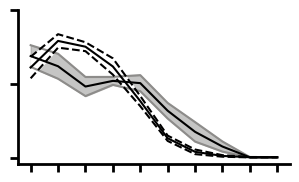

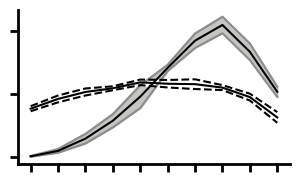

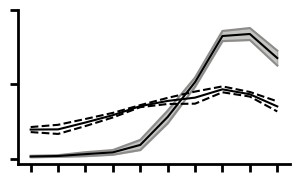

In [148]:
####    GENERATE PLOTS    ####
def gen_lineplotsmouse(df,gene,yticks):
    num_conditions = df['Condition'].nunique()
    X0=df.loc[(df['Gene']==gene) & (df['Condition']==df['Condition'].unique()[0])]['X']*10+0.5
    X1=df.loc[(df['Gene']==gene) & (df['Condition']==df['Condition'].unique()[1])]['X']*10+0.5
    mean0=df.loc[(df['Gene']==gene) & (df['Condition']==df['Condition'].unique()[0])]['Ymean']
    mean1=df.loc[(df['Gene']==gene) & (df['Condition']==df['Condition'].unique()[1])]['Ymean']
    error0=df.loc[(df['Gene']==gene) & (df['Condition']==df['Condition'].unique()[0])]['Ysem']
    error1=df.loc[(df['Gene']==gene) & (df['Condition']==df['Condition'].unique()[1])]['Ysem']
    plt.fill_between(X0,mean0-error0,mean0+error0,color="#8d8c8a",alpha=0.5)
    plt.plot(X0,mean0-error0,color="#8d8c8a",alpha=1)
    plt.plot(X0,mean0+error0,color="#8d8c8a",alpha=1)
    plt.fill_between(X1,mean1-error1,mean1+error1,color="#FFFFFF")
    plt.plot(X1,mean1,color="#000000")
    plt.plot(X0,mean0,color="#000000")
    plt.plot(X1,mean1-error1,color="#000000",linestyle='dashed')
    plt.plot(X1,mean1+error1,color="#000000",linestyle='dashed')
    #plt.legend(["Control","L-KO"])
    plt.yticks(yticks,labels=None)
    plt.gca().set_yticklabels([])
    plt.xticks(range(1,11),labels=None)
    plt.gca().set_xticklabels([])
    plt.tick_params(length=6,width=2)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_linewidth(2)
    plt.gca().spines['left'].set_linewidth(2)
    plt.gcf().set_size_inches(3.5,2)
    plt.savefig(path+gene+"_FOL_TCF7L2_notext_2x3.5_whitegray.png", bbox_inches='tight')
    plt.show()
    plt.close()
    
dfmouse=dfn.groupby(['Condition','Mouse','Gene','X'],group_keys=False)[['Expression Level','Fraction of Lobule']].mean().reset_index()
dfmouse=dfmouse.loc[dfmouse.Gene!="Dapi"]
dfmouse=dfmouse.rename(columns={"Fraction of Lobule":"Y"})
dfmousemean=dfmouse.groupby(['X','Condition','Gene'],as_index=False).agg({'Y': ['mean','sem']})
dfmousemean.columns=dfmousemean.columns.map(''.join)

gen_lineplotsmouse(dfmousemean,genelist[1],[0,0.35,0.7])
gen_lineplotsmouse(dfmousemean,genelist[2],[0,0.1,0.2])
gen_lineplotsmouse(dfmousemean,genelist[3],[0,0.15,0.3])

# gen_lineplotsmouse(dfmousemean,genelist[1],[0,0.15,0.3])
# gen_lineplotsmouse(dfmousemean,genelist[2],[0,0.1,0.2])
# gen_lineplotsmouse(dfmousemean,genelist[3],[0,0.15,0.3])